In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD, Adam
from torch import reshape

import numpy as np
import matplotlib.pyplot as plt

In [3]:
input_size = 784
num_epochs = 100
batch_size = 50
learning_rate = 0.01

M_train = 500
M_test = 200

In [4]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


reduced_train_index=list(range(M_train))
reduced_test_index=list(range(M_test))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_test_dataset=Subset(test_dataset, reduced_test_index)

# Data loader
train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

activation_loader=DataLoader(dataset=subset_train_dataset, batch_size=1, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) 

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.fc1 = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.fc2 = nn.Linear(hidden_sizes[1],hidden_sizes[2])
        self.fc3 = nn.Linear(hidden_sizes[2],hidden_sizes[3])
        self.output_layer = nn.Linear(hidden_sizes[3], output_size)
        
    
    def forward(self, x):
        x_1=self.input_layer(x)
        x_1=x_1.relu()
        x_1=self.fc1(x_1)
        x_1=x_1.relu()
        x_1=self.fc2(x_1)
        x_1=x_1.relu()
        x_2=self.fc3(x_1)
        x_2=x_2.relu()
        x_2=self.output_layer(x_2)
        return x_1,x_2
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [6]:
model = NeuralNet(784,[1024,20,20,20],10)
ReLU_glorot_init(model)

def hidden_layer_activation():
    activations=[]
    for x,y in activation_loader:
        activations.append(model(x.reshape(-1,784))[0].detach().numpy()[0])
    return activations

opt = SGD(model.parameters(), lr=learning_rate)
lossFunc = nn.CrossEntropyLoss()

def training():
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)[1]
        loss = lossFunc(outputs, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()

    activations=[]
    labels=[]
    for x,y in activation_loader:
        labels.append(y)
        activations.append(model(x.reshape(-1,784))[0].detach().numpy()[0])
    return loss.item(), activations, labels

In [7]:
def MI_XT(act,sigma,P):
    kde_bound=0
    for i in act:
        int_sum=0
        for j in act:
            int_sum+=np.exp(-(1/2)*(1/sigma**2)*np.linalg.norm(i-j,ord=2)**2)
        kde_bound+=-(1/P)*np.log((1/P)*int_sum)
    return kde_bound

def MI_TY(act,lab,L,P,sigma):
    kde_bound=MI_XT(act, sigma, P)
    Ps=np.zeros(L)
    lab_act=[[] for k in range(L)]
    for k, y in enumerate(lab):
        lab_act[y].append(act[k])
        Ps[y]+=1
    ps=Ps/P
    for l in range(L):
        kde_bound-=ps[l]*MI_XT(lab_act[l],sigma,Ps[l])
    return kde_bound


In [304]:
mi_xlist=[]
mi_ylist=[]
losses=[]
for n in range(num_epochs):
    l,activations,labels=training()
    losses.append(l)
    mi_xlist.append(MI_XT(activations,np.sqrt(0.1),M_train))
    mi_ylist.append(MI_TY(activations,labels,10,M_train,np.sqrt(0.1)))
    print('Epoch: {} Loss: {:.3f}'.format(n+1,l))

Epoch: 1 Loss: 2.316
Epoch: 2 Loss: 2.219
Epoch: 3 Loss: 2.204
Epoch: 4 Loss: 2.146
Epoch: 5 Loss: 2.160
Epoch: 6 Loss: 2.160
Epoch: 7 Loss: 2.116
Epoch: 8 Loss: 2.060
Epoch: 9 Loss: 2.052
Epoch: 10 Loss: 1.932
Epoch: 11 Loss: 1.935
Epoch: 12 Loss: 1.904
Epoch: 13 Loss: 1.892
Epoch: 14 Loss: 1.761
Epoch: 15 Loss: 1.639
Epoch: 16 Loss: 1.567
Epoch: 17 Loss: 1.612
Epoch: 18 Loss: 1.422
Epoch: 19 Loss: 1.467
Epoch: 20 Loss: 1.248
Epoch: 21 Loss: 1.192
Epoch: 22 Loss: 1.327
Epoch: 23 Loss: 1.243
Epoch: 24 Loss: 1.073
Epoch: 25 Loss: 1.107
Epoch: 26 Loss: 0.790
Epoch: 27 Loss: 0.882
Epoch: 28 Loss: 0.957
Epoch: 29 Loss: 0.846
Epoch: 30 Loss: 0.938
Epoch: 31 Loss: 0.726
Epoch: 32 Loss: 0.825
Epoch: 33 Loss: 0.771
Epoch: 34 Loss: 0.573
Epoch: 35 Loss: 0.749
Epoch: 36 Loss: 0.694
Epoch: 37 Loss: 0.475
Epoch: 38 Loss: 0.382
Epoch: 39 Loss: 0.566
Epoch: 40 Loss: 0.418
Epoch: 41 Loss: 0.472
Epoch: 42 Loss: 0.416
Epoch: 43 Loss: 0.429
Epoch: 44 Loss: 0.388
Epoch: 45 Loss: 0.426
Epoch: 46 Loss: 0.2

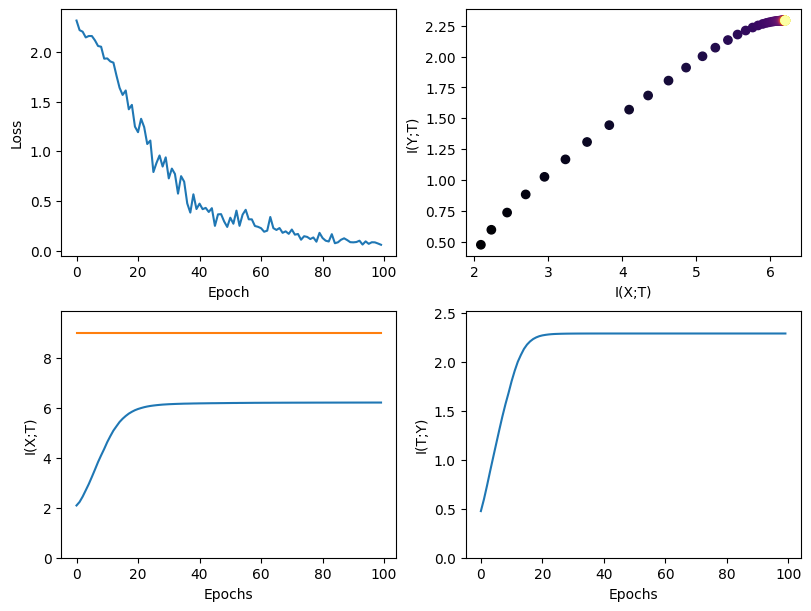

In [311]:
fig, axs = plt.subplots(2,2, figsize=(8,6),layout='constrained')

cm = plt.cm.get_cmap('inferno')

axs[0,0].plot(np.arange(num_epochs),losses)
axs[0,0].set_ylabel('Loss')
axs[0,0].set_xlabel('Epoch')
axs[0,1].scatter(mi_xlist,mi_ylist,c=np.arange(num_epochs),cmap=cm)
axs[0,1].set_ylabel('I(Y;T)')
axs[0,1].set_xlabel('I(X;T)')
axs[1,0].plot(np.arange(num_epochs),mi_xlist)
axs[1,0].plot(np.arange(num_epochs),np.ones(num_epochs)*np.log2(M_train))
axs[1,0].set_ylabel('I(X;T)')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylim((0,np.log2(M_train)*1.1))
axs[1,1].plot(np.arange(num_epochs),mi_ylist)
axs[1,1].set_ylabel('I(T;Y)')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylim((0,max(mi_ylist)*1.1))
#plt.savefig('plots/ReLUMIplot.png')